<a href="https://colab.research.google.com/github/sarthakm1011/Convolutional_Neural_Network/blob/master/Assignment1_StackedEnsembleClassifiers_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP47590: Advanced Machine Learning
# Assignment 1: Building Stacked Ensembles

Name(s): Sarthak Manachanda

Student Number(s): 18204342

## Import Packages Etc

In [61]:
!jupyter nbconvert --to html Assignment1_StackedEnsembleClassifiers_Template.ipynb

[NbConvertApp] WARNING | pattern u'Assignment1_StackedEnsembleClassifiers_Template.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basen

In [56]:
from google.colab import files
src = list(files.upload().values())[0]
open('TAS_Python_Utilities.py','wb').write(src)
import TAS_Python_Utilities

Saving TAS_Python_Utilities.py to TAS_Python_Utilities (1).py


In [0]:
from IPython.display import display, HTML, Image

from TAS_Python_Utilities import data_viz
from TAS_Python_Utilities import data_viz_target
from TAS_Python_Utilities import visualize_tree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from random import randint
import math

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from scipy.spatial import distance
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn.utils import resample
from sklearn.metrics import cohen_kappa_score

%matplotlib inline
#%qtconsole

In [0]:
# #Install Dependencies
!pip install -q kaggle

In [0]:
# # Upload the credentials of the Kaggle account
from google.colab import files
files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sarthak1011","key":"4b91b6b8703154ef11045241c3e961e4"}'}

In [0]:
# # Before importing the datasets we need to run the following code
# # The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# #This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# Now we can import the dataset of interest
!kaggle datasets download -d zalando-research/fashionmnist

 99% 68.0M/68.8M [00:00<00:00, 67.8MB/s]
100% 68.8M/68.8M [00:00<00:00, 83.2MB/s]


In [0]:
# We can see the imnported files from Kaggle
!ls sample_data/

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [0]:
# Now we will unzip the dataset
!unzip fashionmnist.zip

Archive:  fashionmnist.zip
  inflating: t10k-images-idx3-ubyte  
  inflating: fashion-mnist_test.csv  
  inflating: train-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-labels-idx1-ubyte  


In [0]:
import os
import subprocess
from IPython.display import display, HTML, Image
import io
from operator import itemgetter

# from TAS_Python_Utilities import data_viz
# from TAS_Python_Utilities import data_viz_target
# from TAS_Python_Utilities import visualize_tree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from random import randint
from scipy.misc import toimage

from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn import neural_network

%matplotlib inline
#%qtconsole

## Define StackedEnsembleClassifier

Utility function to create classifer objects based on a name (BASE CLASSIFIER)

In [0]:
def create_classifier(classifier_type, tree_min_samples_split = 20):

    if classifier_type == "svm":
        c = svm.SVC(probability=True)

    elif classifier_type == "logreg":
        c = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)

    elif classifier_type == "knn":
        c = neighbors.KNeighborsClassifier()

    elif classifier_type == "tree":
        c = tree.DecisionTreeClassifier(min_samples_split = tree_min_samples_split)

    elif classifier_type == "randomforest":
        c = ensemble.RandomForestClassifier()
        
    else:
        c = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)
    
    return c

StackedEnsembleClassifier class.

In [0]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregation model at the
    aggregation layer.A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the base layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        # Use all training data to train base classifiers
        X_train = X
        y_train = y
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y_train
          
        # Train each base calssifier and generate the stack layer training dataset
        for classifier in self.classifiers_:

            # Extract a bootstrap sample
            X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    
            
            # Train a base classifier
            classifier.fit(X_train_samp, y_train_samp)
            
            # Make predictions for all instances in the training set
            y_pred = classifier.predict_proba(X_train)

            # Append the predictions ot the stack layer traing set (a bit of hacking here!)
            # Appending the predictions of different models here
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]
            except ValueError:
                self.X_stack_train = y_pred
      
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictioonary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

## Test the StackedEnsembleClassifier

Perform a simple test using the StackedEnsembleClassifier on the Iris dataset

In [57]:
from sklearn.datasets import load_iris
iris = load_iris()
clf = StackedEnsembleClassifier()
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(metrics.classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.96      0.98        50
           2       0.96      1.00      0.98        50

   micro avg       0.99      0.99      0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,48,2,50
2,0,0,50,50
All,50,48,52,150


Perform a cross validation experiment

In [58]:
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

[1.         0.93333333 1.         0.93333333 0.93333333 0.93333333
 0.93333333 0.93333333 1.         1.        ]
0.96  +/-  0.03265986323710903


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

## Task 0: Use Fashion MNIST Dataset for all the tasks. 

In [0]:
# Parameter for Grid Search
cv_folds = 2

# Model Test Comparisons
model_test_accuracy_comparisons = dict()
model_valid_accuracy_comparisons = dict()
model_tuned_params_list = dict()

In [0]:
train = pd.read_csv('fashion-mnist_train.csv') # Load Training data 
train = train.sample(frac=0.1) # Sample 10% of the the traning data
y, x = train['label'], train.drop(columns='label') # Target Variable & Input Variable
print(y.shape)
print(x.shape)

(6000,)
(6000, 784)


In [59]:
# Some Standard Statistical Measures about the dataset
if(train.select_dtypes(include=[np.number]).shape[1] > 0):
    display(train.select_dtypes(include=[np.number]).describe())
if(train.select_dtypes(include=[np.object]).shape[1] > 0):
    display(train.select_dtypes(include=[np.object]).describe())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,...,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,4.520667,0.000667,0.002667,0.019000,0.082833,0.245833,0.460667,0.943000,2.326333,5.720833,...,34.102500,23.040000,16.084667,18.125667,23.571500,19.084167,9.243500,2.799667,0.743833,0.067500
std,2.890265,0.040823,0.089410,0.201608,1.859359,4.948179,6.575763,9.332199,15.019946,23.432828,...,57.108878,48.455915,41.070504,44.484151,52.686774,46.664094,30.464562,17.175080,8.170414,2.395183
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,56.000000,9.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,3.000000,5.000000,5.000000,92.000000,217.000000,188.000000,219.000000,218.000000,229.000000,...,255.000000,250.000000,254.000000,252.000000,250.000000,244.000000,218.000000,228.000000,192.000000,142.000000


In [0]:
x = x / 255 # Normalising
X_train_plus_valid, x_test, y_train_plus_valid, y_test = train_test_split(x, y, random_state=0, train_size = 0.7) # Split into training and testing
x_train, x_val, y_train, y_val = train_test_split(X_train_plus_valid, y_train_plus_valid, random_state=0,train_size = 0.5/0.7) # Split training into validation
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(3000, 784)
(1200, 784)
(1800, 784)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [60]:
test_dataset = pd.read_csv('fashion-mnist_test.csv') # Final Testing Fashion Mnist data
test_x = test_dataset[test_dataset.columns[1:]] # 784 input features
test_y = np.array(test_dataset["label"]) # Target Variable
test_x = test_x/255 # Normalising
test_dataset.head() # Display top rows

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Task 1: Design the StackedEnsembleHoldOut Class

In [0]:
# This class uses a hold-out(validation) test set to generate the predictions of the stack.
class StackedEnsembleClassifierHoldout(BaseEstimator, ClassifierMixin):
    """Hold out class for the Stacked Ensemble Classifier""" 
   
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier ."""     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y, x_holdout, y_holdout):
        """Build a SuperLearner classifier from the training set 70% of the total set."""    
        
        # Check that X and y have correct shape
        
        X, y = check_X_y(X, y)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifiers in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        # Use all training data to train base classifiers
        X_train = X
        y_train = y
        x_holdout_test = x_holdout
        y_holdout_test = y_holdout
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y_train
        
        self.X_stack_test = None
        self.Y_stack_test = y_holdout
          
        # Generating Stack Layer dataset
        # +++++++++++++++++++++++++++++++++++
        # For generating we will use Holdout Test set instead of the training data
        # Train each base calssifier and generate the stack layer training dataset
        for classifier in self.classifiers_:

            # Extract a bootstrap sample
            X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    
            
            # Train a base classifier
            classifier.fit(X_train_samp, y_train_samp)
            
            # Make predictions for all instances in the training set
            #y_pred = classifier.predict_proba(X_train)
            y_pred = classifier.predict_proba(x_holdout)

            # Append the predictions ot the stack layer traing set (a bit of hacking here!)
            # Appending the predictions of different models here
#             try:
#                 self.X_stack_train = np.c_[self.X_stack_train, y_pred]
#             except ValueError:
#                 self.X_stack_train = y_pred
                
            try:
                self.X_stack_test = np.c_[self.X_stack_test, y_pred]
            except ValueError:
                self.X_stack_test = y_pred
      
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        # self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
        print(self.X_stack_test.shape)
        print(self.Y_stack_test.shape)
        self.stack_layer_classifier_.fit(self.X_stack_test, self.Y_stack_test)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X."""
        
        # Check is fit had been called by confirming that the teamplates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X."""
        
        # Check is fit had been called by confirming that the teamplates_ dictioonary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

## Task 2: Design the StackedEnsembleKFold Class

In [0]:
# Write your code here
# This class uses a K-Fold Training Technique set to generate the predictions of the stack.
# Explanation inside the training is given as per the Iris dataset which has 150 samples in train set.
class StackedEnsembleClassifierKFold(BaseEstimator, ClassifierMixin):
    """K Fold class for the Stacked Ensemble Classifier""" 
    
    ## 1) Divide dataset into K folds
    ## 2) Iteratively train K times for each of the K fold as Train Set(0.7) on the whole for training
    ## 3) Finally after training predict the values on the validation set(0.3)
    ## 4) Check performance
   
    
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier ."""     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set 70% of the total set."""    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        # Use all training data to train base classifiers
        X_train = X
        y_train = y
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        #self.y_stack_train = y_train
        self.y_stack_train = None
        self.X_kfold_stack_train = None
        self.y_kfold_stack_train = None
        
        # Training each classifier on K-FOLD and generate Stack Layer training dataset
        # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
        skf = StratifiedKFold(n_splits=5)
        count = 0
        
        
        
        for train_index, test_index in skf.split(X_train,y_train):
            print(count)
            count += 1
            #print(train_index.shape)
            #print(test_index.shape)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            #print(X_train.shape) # 120,4
            #print(y_train.shape) # 120
            #print(X_test.shape) # 30, 4
            #print(y_test.shape) # 30
            
            # This loop will go for 5 times
            # 30 predictions for each classifier 30 x 24 shape X_stack_train
            # 
            self.X_stack_train = None #(dtype = float)
            
            # Train each base classifier and generate the stack layer training dataset
            for classifier in self.classifiers_:

                # Extract a bootstrap sample
                X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    

                # Train a base classifier
                classifier.fit(X_train_samp, y_train_samp)

                # Make predictions for all instances in the training set
                y_pred = classifier.predict_proba(X_test)
                #print(y_pred.shape)
                # Append the predictions ot the stack layer traing set (a bit of hacking here!)
                # Appending the predictions of different models here
                try:
                    self.X_stack_train = np.c_[self.X_stack_train, y_pred]
                    #self.y_stack_train = np.c_[self.y_stack_train, y_test]
                except ValueError:
                    self.X_stack_train = y_pred
                    #self.y_stack_train = y_test
                    
            #print(self.X_stack_train.shape)
            #print(self.y_stack_train.shape)
            
            try:
                self.X_kfold_stack_train = np.r_[self.X_kfold_stack_train, self.X_stack_train]
                self.y_kfold_stack_train = np.r_[self.y_kfold_stack_train, y_test]
            except ValueError:
                self.X_kfold_stack_train = self.X_stack_train
                self.y_kfold_stack_train = y_test
      
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))
        
        print(self.X_kfold_stack_train.shape)
        print(self.y_kfold_stack_train.shape)
#         print(self.X_stack_train.shape)
#         print(self.y_stack_train.shape)
        # Train the stack layer using the newly created dataset
        #self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
        self.stack_layer_classifier_.fit(self.X_kfold_stack_train, self.y_kfold_stack_train) 
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X."""
        
        # Check is fit had been called by confirming that the teamplates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
                
        # X has 72 expecting 360
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X."""
        
        # Check is fit had been called by confirming that the teamplates_ dictioonary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        
        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

## Task 3: Compare the Performance of Different Stack Layer Approaches

#### StackedEnsembleClassifier

In [0]:
# StackedEnsembleClassifier
clf = StackedEnsembleClassifier()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_val)
print(metrics.classification_report(y_val, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(y_val), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
accuracy = metrics.accuracy_score(y_val, y_pred) 
model_test_accuracy_comparisons["StackedEnsembleClassifier"] = accuracy
print("Accuracy: " +  str(accuracy*100))

In [0]:
# Train model on full dataset (including x_test) part of the training before finally running on the test dataset
clf.fit(x,y)
y_pred = clf.predict(test_x) # Predict the classifier
print(metrics.classification_report(test_y, y_pred))
print("Confusion Matrix")
accuracy = metrics.accuracy_score(test_y, y_pred) 
print("Accuracy: " +  str(accuracy*100) + "%")

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1000
           1       0.95      0.97      0.96      1000
           2       0.74      0.73      0.74      1000
           3       0.85      0.85      0.85      1000
           4       0.75      0.75      0.75      1000
           5       0.92      0.91      0.91      1000
           6       0.61      0.56      0.58      1000
           7       0.90      0.89      0.89      1000
           8       0.94      0.95      0.94      1000
           9       0.90      0.94      0.92      1000

   micro avg       0.83      0.83      0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

Confusion Matrix
Accuracy: 83.33%


#### StackedEnsembleClassifierHoldout

In [0]:
# StackedEnsembleClassifierHoldout
stacked_ensemble_holdout = StackedEnsembleClassifierHoldout() # Create the classifier
stacked_ensemble_holdout.fit(x_train, y_train, x_val, y_val) # Train the classifier
ensemble_pred = stacked_ensemble_holdout.predict(x_val) # Predict the classifier
print(metrics.classification_report(y_val, ensemble_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(y_val), ensemble_pred, rownames=['True'], colnames=['Predicted'], margins=True))
accuracy = metrics.accuracy_score(y_val, ensemble_pred) 
model_test_accuracy_comparisons["StackedEnsembleClassifierHoldout"] = accuracy
print("Accuracy: " +  str(accuracy*100))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

(1200, 240)
(1200,)
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       118
           1       1.00      0.96      0.98       120
           2       0.85      0.83      0.84       127
           3       0.89      0.88      0.89       110
           4       0.82      0.89      0.85       121
           5       0.96      0.94      0.95       122
           6       0.80      0.67      0.73       106
           7       0.95      0.93      0.94       139
           8       0.93      0.99      0.96       116
           9       0.91      0.94      0.93       121

   micro avg       0.90      0.90      0.90      1200
   macro avg       0.89      0.89      0.89      1200
weighted avg       0.90      0.90      0.89      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,106,0,3,4,0,0,3,0,2,0,118
1,1,115,0,3,1,0,0,0,0,0,120
2,1,0,105,0,14,0,7,0,0,0,127
3,5,0,2,97,1,0,4,0,1,0,110
4,1,0,4,2,108,0,4,0,2,0,121
5,0,0,0,0,0,115,0,2,1,4,122
6,13,0,10,3,7,0,71,0,2,0,106
7,0,0,0,0,0,3,0,129,0,7,139
8,0,0,0,0,1,0,0,0,115,0,116


Accuracy: 89.58333333333334


In [0]:
# Train model on full dataset (including x_test) part of the training before finally running on the test dataset
stacked_ensemble_holdout.fit(x,y,x_test,y_test)
y_pred = stacked_ensemble_holdout.predict(test_x) # Predict the classifier
print(metrics.classification_report(test_y, y_pred))
print("Confusion Matrix")
accuracy = metrics.accuracy_score(test_y, y_pred) 
print("Accuracy: " +  str(accuracy*100) + "%")

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

(1800, 240)
(1800,)
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1000
           1       0.96      0.97      0.96      1000
           2       0.74      0.76      0.75      1000
           3       0.84      0.86      0.85      1000
           4       0.76      0.75      0.75      1000
           5       0.92      0.92      0.92      1000
           6       0.63      0.56      0.60      1000
           7       0.92      0.88      0.90      1000
           8       0.93      0.95      0.94      1000
           9       0.90      0.96      0.93      1000

   micro avg       0.84      0.84      0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Confusion Matrix
Accuracy: 83.84%


#### StackedEnsembleClassifierKFold

In [0]:
# StackedEnsembleClassifierKFold
stacked_ensemble_kfold = StackedEnsembleClassifierKFold() # Create the classifier
stacked_ensemble_kfold.fit(x_train, y_train) # Train the classifier
ensemble_pred = stacked_ensemble_kfold.predict(x_val) # Predict the classifier
print(metrics.classification_report(y_val, ensemble_pred))
print("Confusion Matrix")
accuracy = metrics.accuracy_score(y_val, ensemble_pred) 
model_test_accuracy_comparisons["StackedEnsembleClassifierKFold"] = accuracy
print("Accuracy: " +  str(accuracy*100))

0


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

1


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

2


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

3


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

4


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

(3000, 240)
(3000,)
              precision    recall  f1-score   support

           0       0.80      0.75      0.78       118
           1       0.98      0.95      0.97       120
           2       0.72      0.71      0.71       127
           3       0.80      0.83      0.81       110
           4       0.75      0.81      0.78       121
           5       0.91      0.93      0.92       122
           6       0.58      0.55      0.56       106
           7       0.95      0.88      0.91       139
           8       0.91      0.95      0.93       116
           9       0.89      0.94      0.92       121

   micro avg       0.83      0.83      0.83      1200
   macro avg       0.83      0.83      0.83      1200
weighted avg       0.83      0.83      0.83      1200

Confusion Matrix
Accuracy: 83.33333333333334


In [0]:
# Train model on full dataset (including x_test) part of the training before finally running on the test dataset
stacked_ensemble_kfold.fit(x,y)
y_pred = stacked_ensemble_kfold.predict(test_x) # Predict the classifier
print(metrics.classification_report(test_y, y_pred))
print("Confusion Matrix")
accuracy = metrics.accuracy_score(test_y, y_pred) 
print("Accuracy: " +  str(accuracy*100) + "%")

0


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

1


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

2


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

3


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

4


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

(6000, 240)
(6000,)
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      1000
           1       0.95      0.97      0.96      1000
           2       0.77      0.73      0.75      1000
           3       0.84      0.85      0.85      1000
           4       0.74      0.78      0.76      1000
           5       0.92      0.92      0.92      1000
           6       0.62      0.55      0.58      1000
           7       0.91      0.89      0.90      1000
           8       0.94      0.94      0.94      1000
           9       0.91      0.95      0.93      1000

   micro avg       0.84      0.84      0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Confusion Matrix
Accuracy: 83.86%


## Task 4: Comparing the Performance of Different Stack Layer Approaches with  More Standard Approaches

#### DECISION TREE

In [0]:
# DECISION TREE
my_tree = tree.DecisionTreeClassifier(criterion="entropy")
my_tree.fit(x_train,y_train)
tree_pred = my_tree.predict(x_val) # Predict the classifier
print(metrics.classification_report(y_val, tree_pred))
print("Confusion Matrix")
accuracy = metrics.accuracy_score(y_val, tree_pred)
model_test_accuracy_comparisons["Decision Trees"] = accuracy
print("Accuracy: " +  str(accuracy*100))

              precision    recall  f1-score   support

           0       0.69      0.68      0.68       118
           1       0.90      0.86      0.88       120
           2       0.67      0.61      0.64       127
           3       0.68      0.75      0.72       110
           4       0.67      0.63      0.65       121
           5       0.81      0.83      0.82       122
           6       0.45      0.50      0.47       106
           7       0.85      0.76      0.81       139
           8       0.84      0.89      0.87       116
           9       0.81      0.87      0.84       121

   micro avg       0.74      0.74      0.74      1200
   macro avg       0.74      0.74      0.74      1200
weighted avg       0.74      0.74      0.74      1200

Confusion Matrix
Accuracy: 74.0


In [0]:
# Set up the parameter grid to seaerch
param_grid ={'criterion': ['gini', "entropy"], \
             'max_depth': list(range(3, 50, 3)), \
             'min_samples_split': [200]}

# Perform the search
my_tuned_tree = GridSearchCV(tree.DecisionTreeClassifier(), \
                                param_grid, cv=cv_folds, verbose = 2, \
                            return_train_score=True)
my_tuned_tree.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
display(my_tuned_tree.best_params_)
model_tuned_params_list["Tuned Tree"] = my_tuned_tree.best_params_
display(my_tuned_tree.best_score_)
display(my_tuned_tree.cv_results_)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=6, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=6, min_samples_split=200, total=   0.4s
[CV] criterion=gini, max_depth=6, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=6, min_samples_split=200, total=   0.4s
[CV] criterion=gini, max_depth=9, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=9, min_samples_split=200, total=   0.5s
[CV] criterion=gini, max_depth=9, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=9, min_samples_split=200, total=   0.4s
[CV] criterion=gini, max_depth=12, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=12, min_samples_split=200, total=   0.5s
[CV] criterion=gini, max_depth=12, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=12, min_samples_split=200, total=   0.4s
[CV] criterion=gini, max_depth=15, min_samples_split=200 ...........

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   45.1s finished


Best parameters set found on development set:


{'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 200}

0.700952380952381

{'mean_fit_time': array([0.29448283, 0.42108941, 0.44115055, 0.44507313, 0.44112444,
        0.43996775, 0.43874156, 0.43382311, 0.43686712, 0.44194961,
        0.44141936, 0.45091712, 0.4500761 , 0.44687653, 0.44812226,
        0.44343555, 0.57316208, 0.96040583, 0.97964227, 0.99003637,
        0.9885267 , 0.98737872, 0.97798681, 0.9887563 , 0.98554099,
        0.98781598, 0.97389686, 0.97727358, 0.9812398 , 0.97840536,
        0.98145401, 0.9782927 ]),
 'mean_score_time': array([0.0061326 , 0.00597024, 0.0056237 , 0.00541246, 0.0051446 ,
        0.00508976, 0.00509417, 0.00492704, 0.00557244, 0.00556517,
        0.00513995, 0.00565541, 0.00548434, 0.00553143, 0.00549781,
        0.00536382, 0.00551021, 0.00547147, 0.00541949, 0.0055691 ,
        0.00578976, 0.00543547, 0.00553071, 0.00535429, 0.00545824,
        0.00549948, 0.00541639, 0.0058527 , 0.0054028 , 0.00549626,
        0.00540471, 0.0058527 ]),
 'mean_test_score': array([0.49452381, 0.68071429, 0.67785714, 0.67904762, 0.679

In [0]:
# Make a set of predictions for the test data
y_pred = my_tuned_tree.predict(x_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7233333333333334
              precision    recall  f1-score   support

           0       0.69      0.78      0.73       207
           1       0.94      0.82      0.88       184
           2       0.67      0.62      0.64       193
           3       0.60      0.70      0.65       166
           4       0.58      0.63      0.60       175
           5       0.72      0.84      0.78       159
           6       0.58      0.46      0.52       192
           7       0.82      0.84      0.83       173
           8       0.79      0.78      0.79       165
           9       0.88      0.79      0.83       186

   micro avg       0.72      0.72      0.72      1800
   macro avg       0.73      0.73      0.72      1800
weighted avg       0.73      0.72      0.72      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,161,0,6,20,0,0,15,0,5,0,207
1,4,151,1,20,0,2,6,0,0,0,184
2,2,0,119,0,46,0,19,0,7,0,193
3,14,5,2,117,13,8,5,0,2,0,166
4,6,2,20,17,110,0,14,0,6,0,175
5,1,0,0,3,0,134,0,14,2,5,159
6,43,0,26,4,21,0,89,0,9,0,192
7,0,0,0,0,0,11,0,145,3,14,173
8,2,2,3,9,0,15,3,1,129,1,165


#### BAGGING CLASSIFIER 

In [0]:
# BAGGING CLASSIFIER
my_model = ensemble.BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf = 50), n_estimators=10)
my_model.fit(x_train,y_train)
ensemble_pred = my_model.predict(x_val) # Predict the classifier
print(metrics.classification_report(y_val, ensemble_pred))
print("Confusion Matrix")
accuracy = metrics.accuracy_score(y_val, ensemble_pred) 
model_test_accuracy_comparisons["Bagging"] = accuracy
print("Accuracy: " +  str(accuracy*100))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73       118
           1       0.97      0.78      0.87       120
           2       0.68      0.66      0.67       127
           3       0.57      0.72      0.64       110
           4       0.60      0.74      0.67       121
           5       0.73      0.78      0.75       122
           6       0.75      0.31      0.44       106
           7       0.91      0.83      0.86       139
           8       0.75      0.82      0.79       116
           9       0.79      0.90      0.84       121

   micro avg       0.74      0.74      0.74      1200
   macro avg       0.75      0.73      0.73      1200
weighted avg       0.75      0.74      0.73      1200

Confusion Matrix
Accuracy: 73.66666666666667


In [0]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(50, 501, 50)),
  'base_estimator': [tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 200)]}
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.BaggingClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned Bagging"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50, total=  11.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.8s remaining:    0.0s


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50, total=  11.2s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=100 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_spl

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 21.1min finished


Best parameters set found on development set:
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'n_estimators': 300}
0.5488095238095239


In [0]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(x_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Bagging"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6605555555555556
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       207
           1       0.94      0.82      0.88       184
           2       0.55      0.66      0.60       193
           3       0.56      0.73      0.63       166
           4       0.45      0.71      0.56       175
           5       0.73      0.50      0.60       159
           6       0.70      0.08      0.15       192
           7       0.75      0.79      0.77       173
           8       0.68      0.77      0.72       165
           9       0.68      0.88      0.77       186

   micro avg       0.66      0.66      0.66      1800
   macro avg       0.68      0.66      0.64      1800
weighted avg       0.69      0.66      0.64      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,142,2,17,29,0,0,0,0,17,0,207
1,0,151,7,24,0,1,0,0,1,0,184
2,1,0,127,1,59,0,1,0,4,0,193
3,3,2,14,121,5,0,0,0,13,8,166
4,1,1,16,22,125,0,4,0,6,0,175
5,0,1,0,1,0,80,0,35,4,38,159
6,31,2,41,17,76,0,16,0,9,0,192
7,0,0,0,0,0,19,0,137,1,16,173
8,0,2,7,2,10,1,2,1,127,13,165


#### MODEL COMPARISON

In [0]:
display(model_test_accuracy_comparisons)

{'Bagging': 0.7366666666666667,
 'Decision Trees': 0.74,
 'StackedEnsembleClassifierHoldout': 0.8958333333333334,
 'StackedEnsembleClassifierKFold': 0.8333333333333334,
 'Tuned Bagging': 0.6605555555555556,
 'Tuned Tree': 0.7233333333333334}

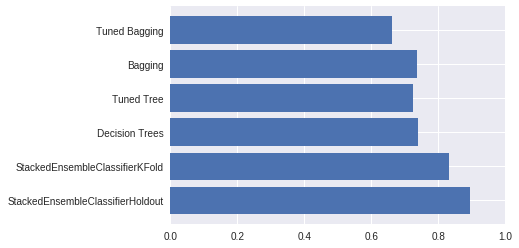

In [0]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.keys()))

In [0]:
display(model_test_accuracy_comparisons)

{'Bagging': 0.7366666666666667,
 'Decision Trees': 0.74,
 'StackedEnsembleClassifierHoldout': 0.8958333333333334,
 'StackedEnsembleClassifierKFold': 0.8333333333333334,
 'Tuned Bagging': 0.6605555555555556,
 'Tuned Tree': 0.7233333333333334}

## Task 5: Implement the StackedEnsembleOneVsOne Class

In [0]:
# Write your code here
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
# A one vs one  stacked ensemble implementation
class StackedEnsembleOneVsOneClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregation model at the
    aggregation layer. A k-fold cross validation is used to generate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the base layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        # Use all training data to train base classifiers
        X_train_full = X
        y_train = y
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        #self.y_stack_train = y_train
        self.y_stack_train = None  
        
        self.X_oneVsOne_stack_train = None
        self.y_oneVsOne_stack_train = None
            
        # TRAINING ONE vs ONE STACK LAYER
        # +++++++++++++++++++++++++++++++++++++++++++++++++++++
        # We train on each subset of 2 classes but we make predictions for 
        # the full data set for the stack layer. Let’s say you have total 150 
        # samples and 3 classes(0,1,2). Also let’s Assume for each 
        # pair(0-1, 0-2, 1-2) we have 50 sample hence total 150 samples.
        # So we train on each pair (in this case on 50 samples) but predict 
        # on the full dataset (150 samples)(As mentioned on the research paper 
        # attached with the question). So our prediction of this layer will
        # have total of 450 samples which will be the training set for 
        # the stack layer.
        
        
        length_classes = self.classes_.size
        for i in range(length_classes):
            for j in range(i+1,length_classes):         
                # getting samples with self.classes_[i] & self.classes_[j]
                
                self.X_stack_train = None
                self.y_stack_train = None
                
                # Creating the training dataset
                X_train = []
                y_train_temp = []
                for k in range(len(y_train)):
                    if ((y_train[k] == self.classes_[i]) or (y_train[k] == self.classes_[j])):
                        X_train.append(X[k])
                        y_train_temp.append(y_train[k])
                
                X_train = np.asarray(X_train)
                y_train_temp = np.asarray(y_train_temp)
                #print(X_train.shape)
                #print(y_train_temp)
                # Train each base calssifier and generate the stack layer training dataset
                for classifier in self.classifiers_:

                    # Extract a bootstrap sample
                    #X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    

                    # Train a base classifier
                    #classifier.fit(X_train_samp, y_train_samp)
                    classifier.fit(X_train, y_train_temp)

                    # Make predictions for all instances in the training set
                    y_pred = classifier.predict_proba(X_train_full)

                    
                    # Append the predictions ot the stack layer traing set (a bit of hacking here!)
                    # Appending the predictions of different models here
                    try:
                        self.X_stack_train = np.c_[self.X_stack_train, y_pred]
                        # np.c_ stacks 1D array as column as into 2D array
                    except ValueError:
                        self.X_stack_train = y_pred
                
                #print(self.X_stack_train.shape)
                # row stack the y and x
                try:
                    self.X_oneVsOne_stack_train = np.r_[self.X_oneVsOne_stack_train, self.X_stack_train]
                    self.y_oneVsOne_stack_train = np.r_[self.y_oneVsOne_stack_train, y_train]
                    # np.c_ stacks 1D array as column as into 2D array
                except ValueError:
                    self.X_oneVsOne_stack_train = self.X_stack_train
                    self.y_oneVsOne_stack_train = y_train
                
        #print(self.X_oneVsOne_stack_train.shape)
        #print(self.y_oneVsOne_stack_train.shape)
      
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_oneVsOne_stack_train, self.y_oneVsOne_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictioonary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

## Task 6 Evaluate the Performance of the StackedEnsembleCalassifierOneVsOne Algorithm

In [0]:
# Write your code here
# Write your code here
stacked_ensemble_oneVsOne = StackedEnsembleOneVsOneClassifier() # Create the classifier
stacked_ensemble_oneVsOne.fit(x_train, y_train) # Train the classifier
ensemble_pred = stacked_ensemble_oneVsOne.predict(x_val) # Predict the classifier
accuracy = metrics.accuracy_score(y_val, ensemble_pred) 
print("Accuracy: " +  str(accuracy*100) + "%")

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

Accuracy: 28.499999999999996%


In [52]:
# Make a set of predictions for the test data
y_pred = stacked_ensemble_oneVsOne.predict(x_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned_Ensemble1vs1"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.27111111111111114
              precision    recall  f1-score   support

           0       0.14      0.55      0.23       207
           1       0.15      0.05      0.07       184
           2       0.20      0.11      0.15       193
           3       0.25      0.57      0.35       166
           4       0.00      0.00      0.00       175
           5       0.58      0.41      0.48       159
           6       0.00      0.00      0.00       192
           7       0.64      0.08      0.14       173
           8       0.00      0.00      0.00       165
           9       0.87      0.91      0.89       186

   micro avg       0.27      0.27      0.27      1800
   macro avg       0.28      0.27      0.23      1800
weighted avg       0.28      0.27      0.23      1800

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Predicted,0,1,2,3,4,5,7,8,9,All
True,,,,,,,,,,
0,114,12,40,40,1,0,0,0,0,207
1,26,9,15,134,0,0,0,0,0,184
2,116,12,22,43,0,0,0,0,0,193
3,51,13,6,95,1,0,0,0,0,166
4,147,0,1,27,0,0,0,0,0,175
5,23,0,1,8,15,65,4,42,1,159
6,147,11,22,12,0,0,0,0,0,192
7,14,0,0,18,36,46,14,20,25,173
8,155,5,0,5,0,0,0,0,0,165


In [54]:
# Train model on full dataset (including x_test) part of the training before finally running on the test dataset
stacked_ensemble_oneVsOne.fit(x,y)
y_pred = stacked_ensemble_oneVsOne.predict(test_x) # Predict the classifier
print(metrics.classification_report(test_y, y_pred))
print("Confusion Matrix")
accuracy = metrics.accuracy_score(test_y, y_pred) 
print("Accuracy: " +  str(accuracy*100) + "%")

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

              precision    recall  f1-score   support

           0       0.11      0.66      0.18      1000
           1       0.21      0.22      0.21      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.01      0.00      0.00      1000
           5       0.67      0.00      0.01      1000
           6       0.00      0.00      0.00      1000
           7       0.59      0.26      0.36      1000
           8       0.00      0.00      0.00      1000
           9       0.67      0.95      0.79      1000

   micro avg       0.21      0.21      0.21     10000
   macro avg       0.23      0.21      0.16     10000
weighted avg       0.23      0.21      0.16     10000

Confusion Matrix
Accuracy: 20.880000000000003%


## Task 7 Reflect on the Performance of the Different Models Evaluated

*Write your reflection here (max 300 words)*

*Write your reflection here (max 300 words)*

The overall dataset that we have chosen consists of only 10% of the total MNIST training dataset. This is constant across all the models. Models should behave in a similar manner when 100% data is used. Models are being trained on Google Colab using fashion MNIST dataset directly from Kaggle. The performance of different classifers on test dataset are given below. The performances are compared on the basis of Accuracy & F1 score (harmonic mean of precision and recall). The best value of F1 is 1 and worst value is 0. All the models were evaluated on google colab. LINK: https://colab.research.google.com/drive/1hrFxZ2tKLWCD_Vh9Rh5Vcp7Il7cmC3-8 <br>
<br>
train = train_split + val_split + test_split <br>
test = final test set to make predictions <br>
<br>



-----------------------------------------

##### Stacked Ensemble Classifier ( training on train_split set & testing on val_split set)
Accuracy: **77.58333333333334%** <br>
F1 Score: **0.77**<br>

##### Stacked Ensemble Classifier ( training on full train & testing on test set)
Accuracy: **83.33%** <br>
F1 Score: **0.83** <br>

Obsservation: The F1 score for Ensemble Classification of class '6' is low 0.58 & highest for '1' 0.96 .

-----------------------------------------

##### Stacked Ensemble Classifier with Holdout ( training on train_split set & testing on val_split set)
Accuracy: **89.58333333333334%** <br>
F1 Score: **0.89** <br>

Observation: The F1 score for class '6' is better here 0.73 .

##### Stacked Ensemble Classifier with Holdout ( training on full_train set & testing on test set)
Accuracy: **83.84%%** <br>
F1 Score: **0.84** <br>

Observation: The performance decreased when we used the test set on full training data. 
Reason: Maybe the model didn't generalisie enough.

-----------------------------------------

##### Stacked Ensemble Classifier with KFold  (training on train_split set & testing on val_split set)
Accuracy: **83.33333333333334%** <br>
F1 Score: **0.83** <br>

##### Stacked Ensemble Classifier with KFold  training on full_train set & testing on test set)
Accuracy: **83.86%** <br>
F1 Score: **0.84** <br>

Observation: The classification score of class '6' was again low 0.84


-----------------------------------------

##### Stacked Ensemble Classifier OneVsOne: ( Training with train_split and testing with val_split)
Accuracy: **28.499999999999996%** <br> <br>

-----------------------------------------

#### Best Standard Classifier: 
##### Decision Tree
Validation Accuracy: **74.0%** <br>
Validation F1 Score: **0.74** <br>
Best Parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 200} <br>
Test Accuracy: **72.33%** <br>

##### Bagging Classifier
Validation Accruacy: **73.66666666666667%** <br>
Best Parameters: {'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'n_estimators': 300}
Test_split Accuracy: 66.05555555555556%

### All Models Comparison
{'Bagging': 0.7366666666666667,
 'Decision Trees': 0.74,
 'StackedEnsembleClassifierHoldout': 0.8958333333333334,
 'StackedEnsembleClassifierKFold': 0.8333333333333334,
 'Tuned Bagging': 0.6605555555555556,
 'Tuned Tree': 0.7233333333333334}


The StackedEnsembleClassifierHoldout performed very well compared to the other models.